In [8]:
import uproot
import numpy as np
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import itertools
import awkward as ak
import seaborn as sns
from scipy.optimize import curve_fit
%matplotlib inline

In [9]:
file = uproot.open("tracking_losses_ntuple_Bd2KstEE.root:PrDebugTrackingLosses.PrDebugTrackingTool/Tuple;1")
#file = uproot.open("tracking_losses_ntuple_Dst0ToD0EE.root:PrDebugTrackingLosses.PrDebugTrackingTool/Tuple;1")

#look at particles only from Signal
allcolumns = file.arrays()
tracked = allcolumns[(allcolumns.isElectron) & (~allcolumns.lost) & (allcolumns.fromSignal) & (allcolumns.p > 5e3)]
lost = allcolumns[(allcolumns.isElectron) & (allcolumns.lost) & (allcolumns.fromSignal) & (allcolumns.p > 5e3)] 

#ak.num(tracked, axis=0)



In [10]:
#lost
l_eph = lost["brem_photons_pe"]
ak.nan_to_num(l_eph)
l_pT = lost["pt"]
l_sci_x = lost["scifi_hit_pos_x"]
ak.nan_to_num(l_sci_x)

#found
f_eph = tracked["brem_photons_pe"]
ak.nan_to_num(f_eph)
f_pT = tracked["pt"]
f_sci_x = tracked["scifi_hit_pos_x"]
ak.nan_to_num(f_sci_x)

l_sci_x, l_pT = ak.broadcast_arrays(l_sci_x, l_pT)
f_sci_x, f_pT = ak.broadcast_arrays(f_sci_x, f_pT)

l_sci_x = ak.to_numpy(ak.flatten(l_sci_x))
l_pT = ak.to_numpy(ak.flatten(l_pT))
f_sci_x = ak.to_numpy(ak.flatten(f_sci_x))
f_pT = ak.to_numpy(ak.flatten(f_pT))

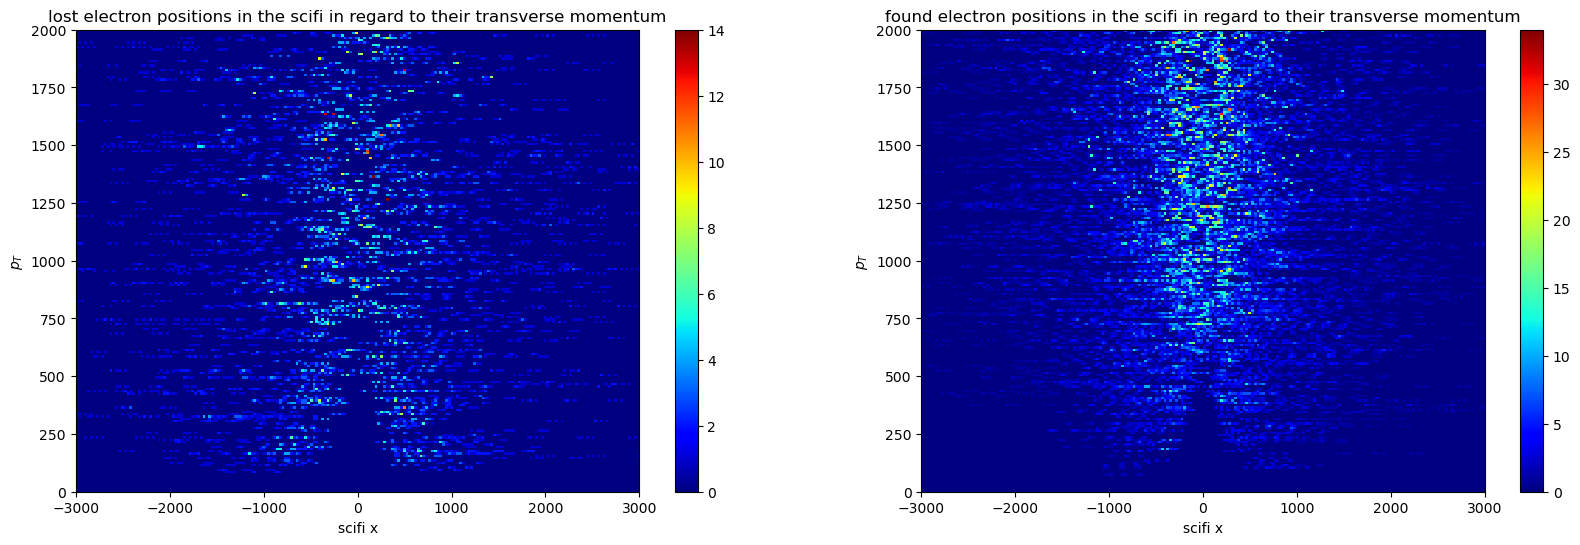

In [11]:
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

a0=ax0.hist2d(l_sci_x, l_pT, bins=200,  cmap=plt.cm.jet, cmin=0, range=[[-3000,3000],[0,2000]])
ax0.set_xlabel("scifi x")
ax0.set_ylabel(r"$p_T$")
ax0.set_title("lost electron positions in the scifi in regard to their transverse momentum")
plt.colorbar(a0[3],ax=ax0)

a1=ax1.hist2d(f_sci_x, f_pT, bins=200,  cmap=plt.cm.jet, cmin=0, range=[[-3000,3000],[0,2000]])
ax1.set_xlabel("scifi x")
ax1.set_ylabel(r"$p_T$")
ax1.set_title("found electron positions in the scifi in regard to their transverse momentum")
plt.colorbar(a1[3],ax=ax1)

"""
B:
we can see that the lost electrons cover a wider spread in the x direction of the scifi tracker, most widely scattered electrons have low pt

D:
heatmaps look fairly similar. lost e are more densely located between x \in [1000,2000]. found e between x \in [200,1500].
we can see a near empty space around the x origin in both. lost seem to have less pt.

"""
plt.show()

In [12]:
energy_found = tracked["energy"]
energy_found = energy_found[tracked["brem_photons_pe_length"]!=0]
#ak.nan_to_num(energy_found)

e_ph_found = tracked["brem_photons_pe"]
e_ph_found = e_ph_found[tracked["brem_photons_pe_length"]!=0]
#ak.nan_to_num(e_ph_found, nan=[0])
e_ph_found = ak.sum(e_ph_found, axis=-1, keepdims=True)
print(e_ph_found)
print(energy_found)

energy_lost = lost["energy"]
energy_lost = energy_lost[lost["brem_photons_pe_length"]!=0]
#ak.nan_to_num(energy_lost)

e_ph_lost = lost["brem_photons_pe"]
e_ph_lost = e_ph_lost[lost["brem_photons_pe_length"]!=0]
#ak.nan_to_num(e_ph_lost)
e_ph_lost = ak.sum(e_ph_lost, axis=-1,keepdims=True)

#e_ph_found, energy_found = ak.broadcast_arrays(e_ph_found, energy_found)
#e_ph_lost, energy_lost = ak.broadcast_arrays(e_ph_lost, energy_lost)

e_ph_found = ak.to_numpy(ak.flatten(e_ph_found))
energy_found = ak.to_numpy(energy_found)

e_ph_lost = ak.to_numpy(ak.flatten(e_ph_lost))
energy_lost = ak.to_numpy(energy_lost)

print(e_ph_found[1])
print(energy_found[1])

[[4.09e+04], [8.66e+03], [8.07e+04], ..., [5.63e+03], [6.29e+03], [2.26e+03]]
[4.62e+04, 9.36e+03, 1.34e+05, 5.63e+04, ..., 2.01e+04, 6.94e+03, 7.83e+03]
8657.132
9355.866625028413


In [13]:
q_e_found = e_ph_found/energy_found
q_e_lost = e_ph_lost/energy_lost

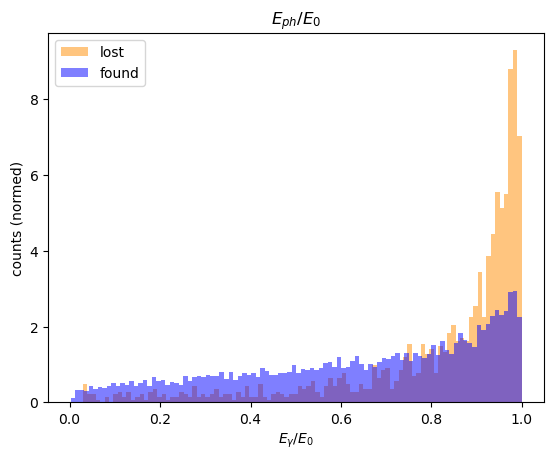

In [14]:
plt.hist(q_e_lost, bins=100, density=True, alpha=0.5, histtype='bar', color="darkorange", label="lost")
plt.hist(q_e_found, bins=100, density=True, alpha=0.5, histtype='bar', color="blue", label="found")
plt.xlabel(r"$E_\gamma/E_0$")
plt.ylabel("counts (normed)")
plt.title(r'$E_{ph}/E_0$')
plt.legend()

"""
B:
we can clearly see that lost electrons are responsible for higher energy photons
D:
still able to see a trend that most electrons that give up all of their energy to photons are lost e. but nowhere near as extreme as for the B decay
"""

plt.show()

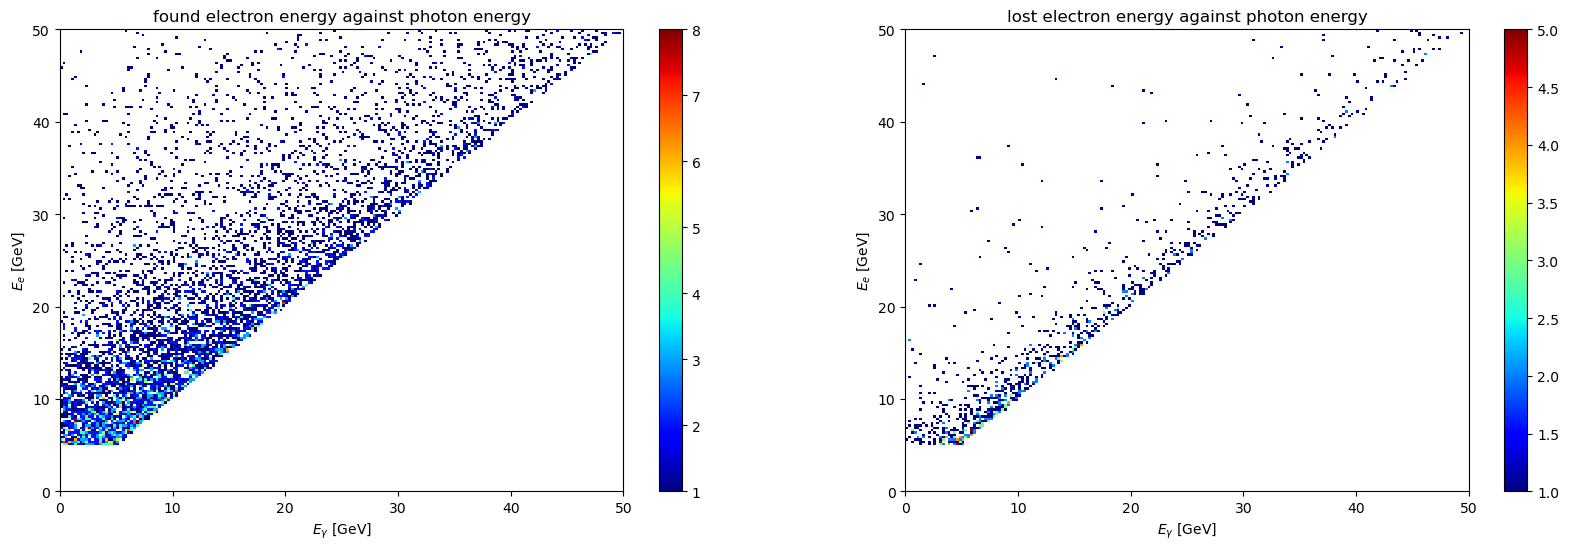

In [17]:
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

a0 = ax0.hist2d(e_ph_found/(1e3), energy_found/(1e3), density=False, bins=200,  cmap=plt.cm.jet, cmin=1, range=[[0,50],[0,50]])
ax0.set_xlabel(r"$E_\gamma$ [GeV]")
ax0.set_ylabel(r"$E_e$ [GeV]")
ax0.set_title("found electron energy against photon energy")
plt.colorbar(a0[3],ax=ax0)

a1 = ax1.hist2d(e_ph_lost/(1e3), energy_lost/(1e3), density=False, bins=200, cmap=plt.cm.jet, cmin=1, range= [[0,50],[0,50]])
ax1.set_xlabel(r"$E_\gamma$ [GeV]")
ax1.set_ylabel(r"$E_e$ [GeV]")
ax1.set_title("lost electron energy against photon energy")
plt.colorbar(a1[3],ax=ax1)

"""
B:
concentrated at the E_ph/E_0~1 line especially at lower energies.
lost E_ph to E_0: fewer entries at lower q_e
D:
both energies are much smaller than in the B decay. otherwise similar pattern.
"""
plt.show()

In [46]:
brem_vtx_x_found = tracked["brem_vtx_x"]
brem_vtx_x_found = brem_vtx_x_found[tracked["brem_vtx_x_length"]!=0]
brem_vtx_x_found = ak.to_numpy(ak.flatten(brem_vtx_x_found))

brem_vtx_z_found = tracked["brem_vtx_z"]
brem_vtx_z_found = brem_vtx_z_found[tracked["brem_vtx_z_length"]!=0]
#print(ak.to_numpy(brem_vtx_z_found))
brem_vtx_z_found = ak.to_numpy(ak.flatten(brem_vtx_z_found))

brem_vtx_x_lost = lost["brem_vtx_x"]
brem_vtx_x_lost = brem_vtx_x_lost[lost["brem_vtx_x_length"]!=0]
brem_vtx_x_lost = ak.to_numpy(ak.flatten(brem_vtx_x_lost))

brem_vtx_z_lost = lost["brem_vtx_z"]
brem_vtx_z_lost = brem_vtx_z_lost[lost["brem_vtx_z_length"]!=0]
brem_vtx_z_lost = ak.to_numpy(ak.flatten(brem_vtx_z_lost))

#vtx_x_fit= ak.to_numpy(vtx_x_found)
#vtx_z_fit = ak.to_numpy(vtx_z_found)

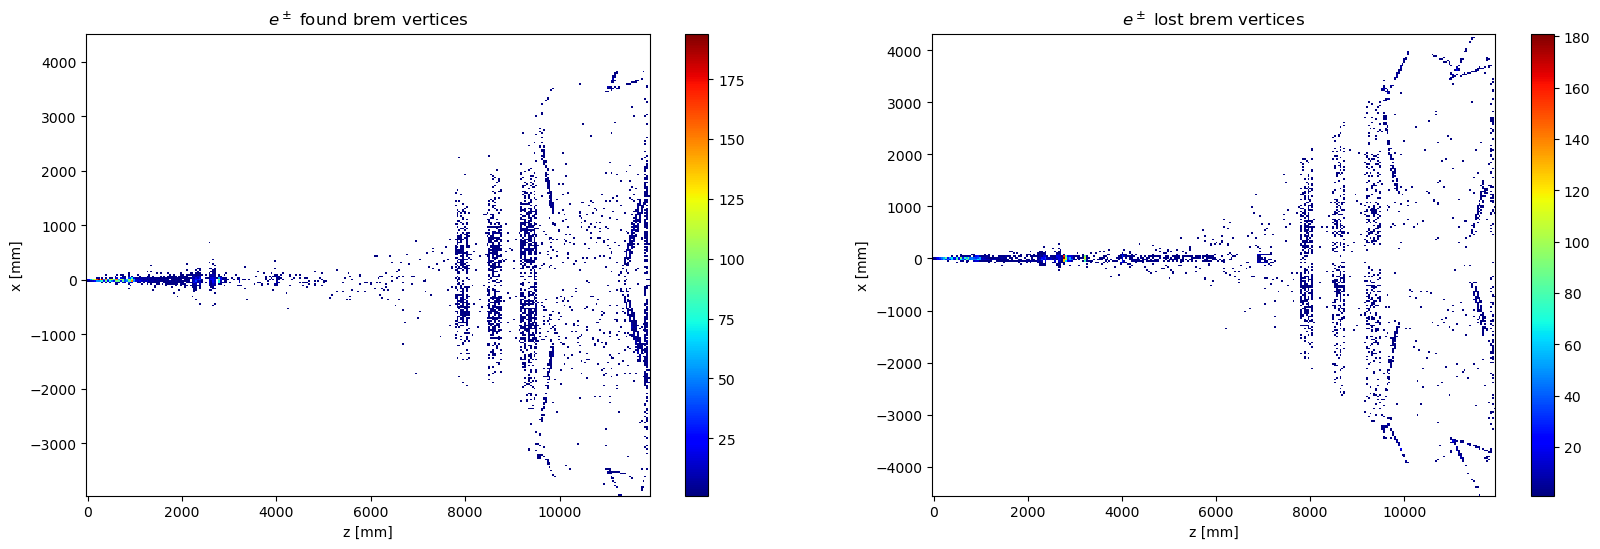

In [47]:
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

a0 = ax0.hist2d(brem_vtx_z_found, brem_vtx_x_found, density=False, bins=300,  cmap=plt.cm.jet, cmin=1)
ax0.set_xlabel("z [mm]")
ax0.set_ylabel("x [mm]")
ax0.set_title(r"$e^\pm$ found brem vertices")

plt.colorbar(a0[3],ax=ax0)

a1 = ax1.hist2d(brem_vtx_z_lost, brem_vtx_x_lost, density=False, bins=300, cmap=plt.cm.jet, cmin=1)
ax1.set_xlabel("z [mm]")
ax1.set_ylabel("x [mm]")
ax1.set_title(r"$e^\pm$ lost brem vertices")
#ax1.set(xlim=(0,4000), ylim=(-1000,1000))

plt.colorbar(a1[3], ax=ax1)

"""
z: VeLo - RICH1 - TT - Magnet - T1,T2,T3 - RICH2 - M1
B:
vertices of lost e photons are more densely concentrated around the beampipe, especially in the z range of the magnet
found: vertices are densely located @ or around the detectors, while there are no clusters in the z range of the magnet
D:
lost brem vertices: we can very clearly see the concentration of vertices @ the beampipe
both: less statistics in general, can still make out the tracking stations but not as well as in the B decay
"""
plt.show()

In [48]:
#plot singular tracks by fitting brem vertices
vtx_z_found = tracked["brem_vtx_z"]
vtx_z_found = vtx_z_found[tracked["brem_vtx_z_length"]>3]

vtx_x_found = tracked["brem_vtx_x"]
vtx_x_found = vtx_x_found[tracked["brem_vtx_x_length"]>3]

vtx_z_lost = lost["brem_vtx_z"]
vtx_z_lost = vtx_z_lost[lost["brem_vtx_z_length"]>3]

vtx_x_lost = lost["brem_vtx_x"]
vtx_x_lost = vtx_x_lost[lost["brem_vtx_x_length"]>3]

def cubic_fit(x, a, b, c, d):
    return (a + b*x + c*x**2 + d*x**3)

def quint_fit(x, a, b, c, d, e, f):
    return (a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5)


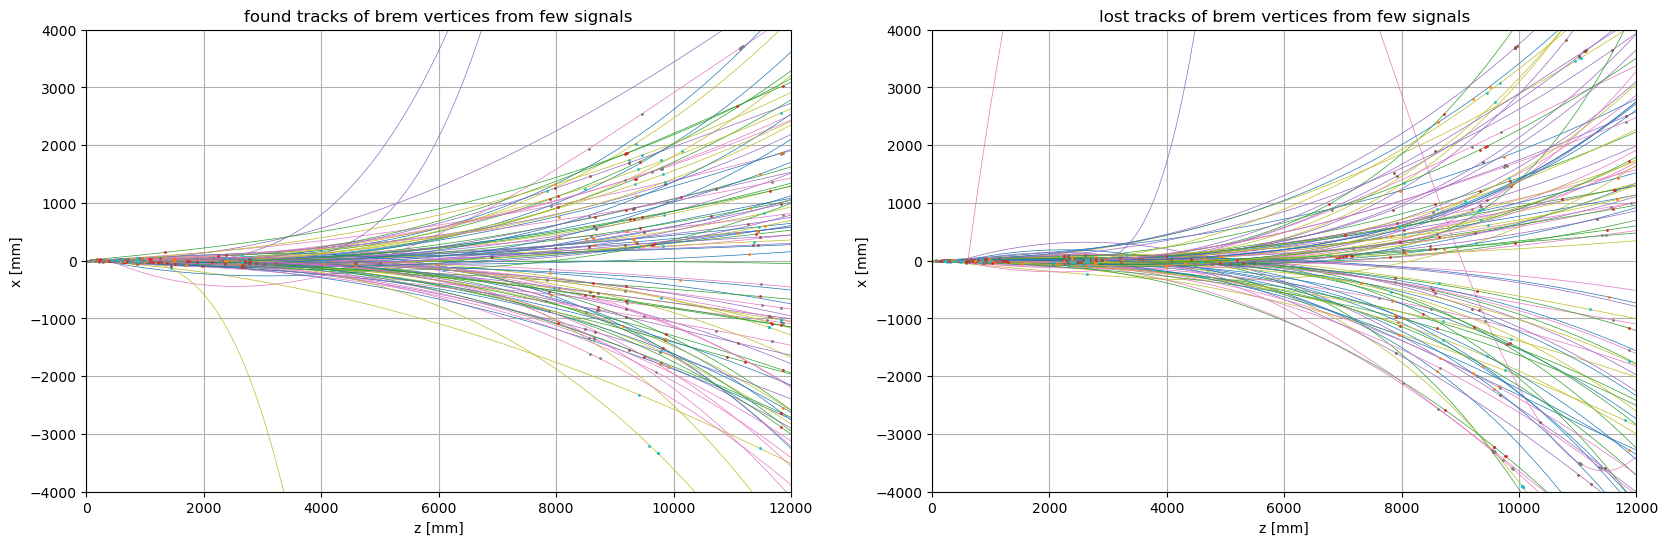

In [32]:
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
n_end=100

for i in range(0,n_end):
    popt, pcov = curve_fit(cubic_fit,ak.to_numpy(vtx_z_found[i,:]),ak.to_numpy(vtx_x_found[i,:]))
    z_coord = np.linspace(vtx_z_found[i,0],12000,1000)
    fit = cubic_fit(z_coord, popt[0], popt[1], popt[2], popt[3])
    ax0.plot(z_coord, fit, "-", label="fit"+str(i), lw=0.5)
    ax0.errorbar(ak.to_numpy(vtx_z_found[i,:]),ak.to_numpy(vtx_x_found[i,:]),fmt=".",ms=2)

#ax0.legend()
ax0.set_xlabel("z [mm]")
ax0.set_ylabel("x [mm]")
ax0.set_title("found tracks of brem vertices from few signals")
ax0.set(xlim=(0,12000), ylim=(-4000,4000))
ax0.grid()

for i in range(0,n_end):
    popt, pcov = curve_fit(cubic_fit,ak.to_numpy(vtx_z_lost[i,:]),ak.to_numpy(vtx_x_lost[i,:]))
    z_coord = np.linspace(vtx_z_lost[i,0],12000,1000)
    fit = cubic_fit(z_coord, popt[0], popt[1], popt[2], popt[3])
    ax1.plot(z_coord, fit, "-", label="fit"+str(i), lw=0.5)
    ax1.errorbar(ak.to_numpy(vtx_z_lost[i,:]),ak.to_numpy(vtx_x_lost[i,:]),fmt=".",ms=2)

#ax1.legend()
ax1.set_xlabel("z [mm]")
ax1.set_ylabel("x [mm]")
ax1.set_title("lost tracks of brem vertices from few signals")
ax1.set(xlim=(0,12000), ylim=(-4000,4000))
ax1.grid()

"""
B:
we can see that of the lost brem vertices, many trajectory fits seem illogical and not plausible
found: most seem like reasonable tracks
D:
both: many tracks arent good fits and are unusable
"""

plt.show()

In [49]:
endvtx_x_found = tracked["all_endvtx_x"]
endvtx_x_found = endvtx_x_found[tracked["all_endvtx_x_length"]!=0]
endvtx_x_found = ak.to_numpy(ak.flatten(endvtx_x_found))

endvtx_z_found = tracked["all_endvtx_z"]
endvtx_z_found = endvtx_z_found[tracked["all_endvtx_z_length"]!=0]
#print(ak.to_numpy(brem_vtx_z_found))
endvtx_z_found = ak.to_numpy(ak.flatten(endvtx_z_found))

endvtx_x_lost = lost["all_endvtx_x"]
endvtx_x_lost = endvtx_x_lost[lost["all_endvtx_x_length"]!=0]
endvtx_x_lost = ak.to_numpy(ak.flatten(endvtx_x_lost))

endvtx_z_lost = lost["all_endvtx_z"]
endvtx_z_lost = endvtx_z_lost[lost["all_endvtx_z_length"]!=0]
endvtx_z_lost = ak.to_numpy(ak.flatten(endvtx_z_lost))

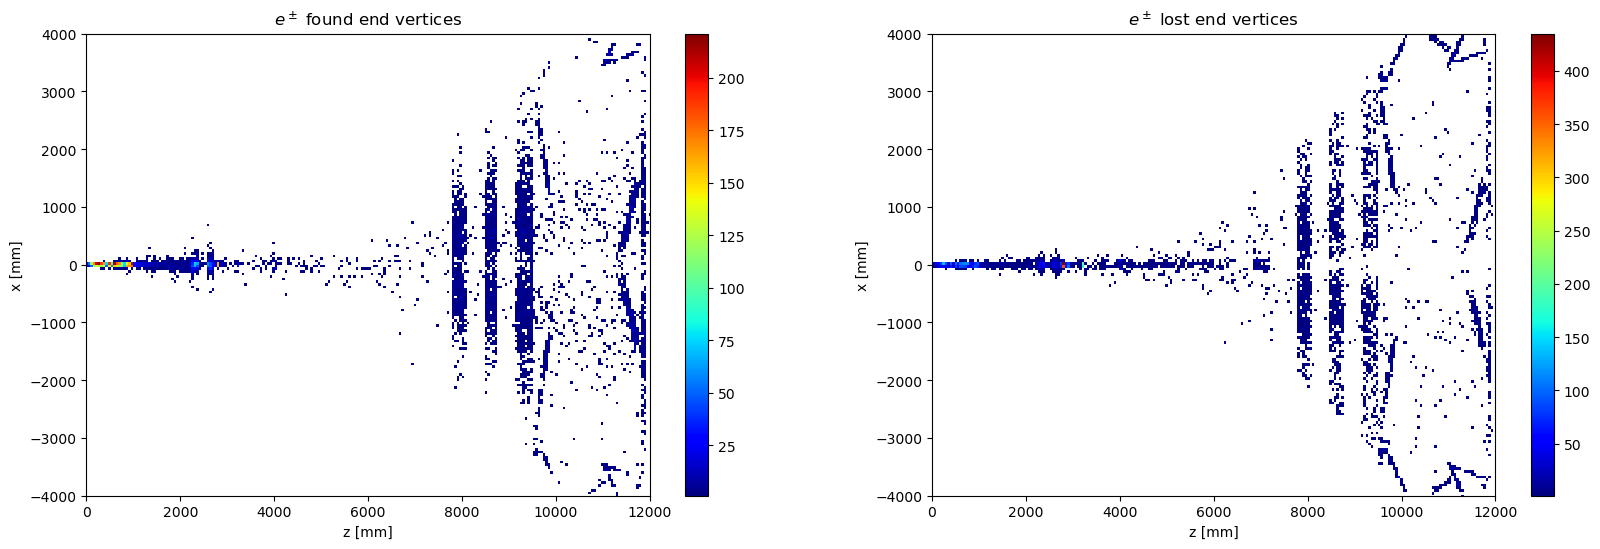

In [50]:
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

a0 = ax0.hist2d(endvtx_z_found, endvtx_x_found, density=False, bins=500,  cmap=plt.cm.jet, cmin=1)
ax0.set_xlabel("z [mm]")
ax0.set_ylabel("x [mm]")
ax0.set_title(r"$e^\pm$ found end vertices")
ax0.set(xlim=(0,12000), ylim=(-4000,4000))

plt.colorbar(a0[3],ax=ax0)

a1 = ax1.hist2d(endvtx_z_lost, endvtx_x_lost, density=False, bins=500, cmap=plt.cm.jet, cmin=1)
ax1.set_xlabel("z [mm]")
ax1.set_ylabel("x [mm]")
ax1.set_title(r"$e^\pm$ lost end vertices")
ax1.set(xlim=(0,12000), ylim=(-4000,4000))

plt.colorbar(a1[3], ax=ax1)

"""
z: VeLo - RICH1 - TT - Magnet - T1,T2,T3 - RICH2 - M1
B:
vertices of lost e photons are more densely concentrated around the beampipe, especially in the z range of the magnet
found: vertices are densely located @ or around the detectors, while there are no clusters in the z range of the magnet
D:
lost: densely located @ the beampipe.
both: almost cant make out the velo or ut
"""
plt.show()

In [51]:
# try to plot trajectories using all tracker hits (Velo, UT, SciFi)

velo_x_found = tracked["velo_hit_pos_x"]
velo_z_found = tracked["velo_hit_pos_z"]
ut_x_found = tracked["ut_hit_pos_x"]
ut_z_found = tracked["ut_hit_pos_z"]
scifi_x_found = tracked["scifi_hit_pos_x"]
scifi_z_found = tracked["scifi_hit_pos_z"]

tracker_x_found = ak.concatenate([velo_x_found,ut_x_found,scifi_x_found], axis=1)
tracker_z_found = ak.concatenate([velo_z_found,ut_z_found,scifi_z_found], axis=1)

velo_x_lost = lost["velo_hit_pos_x"]
velo_z_lost = lost["velo_hit_pos_z"]
ut_x_lost = lost["ut_hit_pos_x"]
ut_z_lost = lost["ut_hit_pos_z"]
scifi_x_lost = lost["scifi_hit_pos_x"]
scifi_z_lost = lost["scifi_hit_pos_z"]

tracker_x_lost = ak.concatenate([velo_x_lost,ut_x_lost,scifi_x_lost], axis=1)
tracker_z_lost = ak.concatenate([velo_z_lost,ut_z_lost,scifi_z_lost], axis=1)


#tracker_x_found = tracker_x_found[tracked["energy"]>1e4]
#tracker_z_found = tracker_z_found[tracked["energy"]>1e4]

#tracker_x_lost = tracker_x_lost[lost["energy"]>1e4]
#tracker_z_lost = tracker_z_lost[lost["energy"]>1e4]

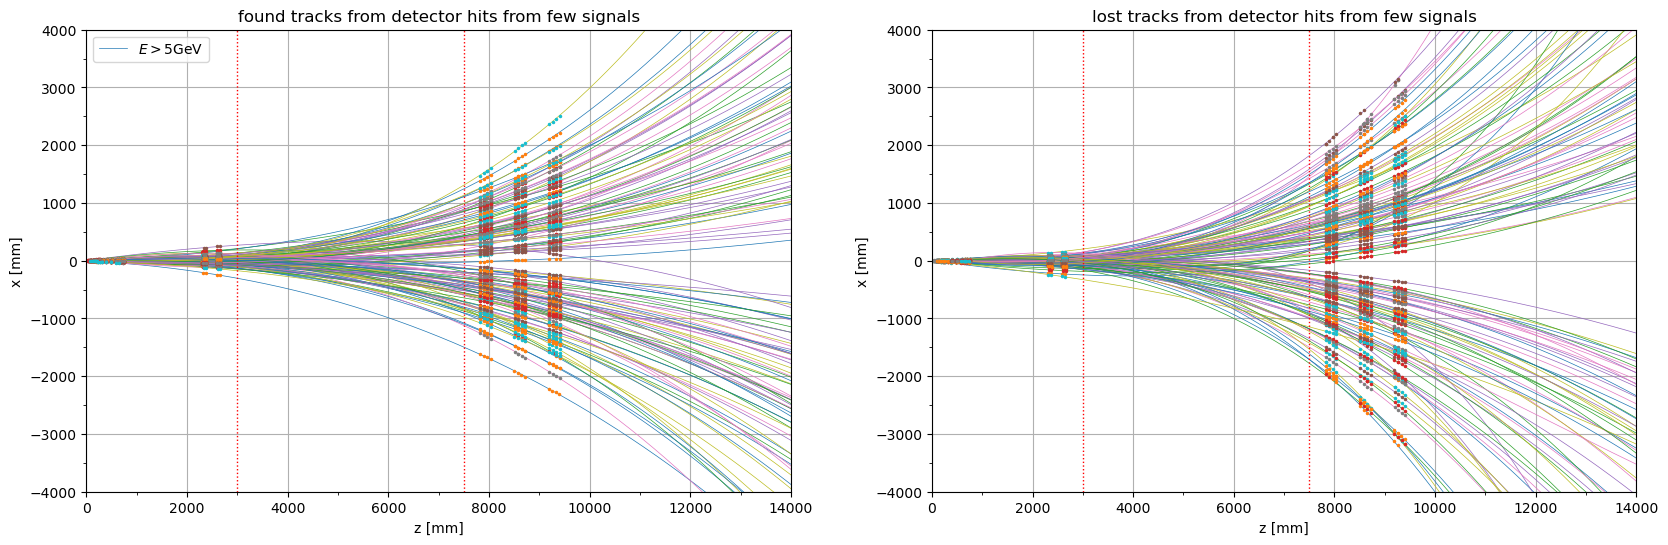

In [52]:
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

nstart=0
nend=130

for i in range(nstart,nend):
    popt, pcov = curve_fit(cubic_fit,ak.to_numpy(tracker_z_found[i,:]),ak.to_numpy(tracker_x_found[i,:]))
    z_coord = np.linspace(tracker_z_found[i,0],14000,1000)
    fit = cubic_fit(z_coord, popt[0], popt[1], popt[2], popt[3])
    ax0.plot(z_coord, fit, "-", lw=0.5)
    ax0.errorbar(ak.to_numpy(tracker_z_found[i,:]),ak.to_numpy(tracker_x_found[i,:]),fmt=".",ms=3)

ax0.legend([r"$E>5$GeV"])
ax0.vlines(3000, -4000,4000, lw=1, ls=":", color="red")
ax0.vlines(7500, -4000,4000, lw=1, ls=":", color="red")
ax0.set_xticks(np.arange(0,14000,1000) , minor=True)
ax0.set_yticks(np.arange(-4000,4000,500), minor=True)
ax0.set_xlabel("z [mm]")
ax0.set_ylabel("x [mm]")
ax0.set_title("found tracks from detector hits from few signals")
ax0.set(xlim=(0,14000), ylim=(-4000,4000))
ax0.grid()

for i in range(nstart,nend):
    popt, pcov = curve_fit(cubic_fit,ak.to_numpy(tracker_z_lost[i,:]),ak.to_numpy(tracker_x_lost[i,:]))
    z_coord = np.linspace(tracker_z_lost[i,0],14000,1000)
    fit = cubic_fit(z_coord, popt[0], popt[1], popt[2], popt[3])
    ax1.plot(z_coord, fit, "-", lw=0.5)
    ax1.errorbar(ak.to_numpy(tracker_z_lost[i,:]),ak.to_numpy(tracker_x_lost[i,:]),fmt=".",ms=3)

ax1.vlines(3000, -4000,4000, lw=1, ls=":", color="red")
ax1.vlines(7500, -4000,4000, lw=1, ls=":", color="red")
ax1.set_xticks(np.arange(0,14000,1000) , minor=True)
ax1.set_yticks(np.arange(-4000,4000,500), minor=True)
ax1.set_xlabel("z [mm]")
ax1.set_ylabel("x [mm]")
ax1.set_title("lost tracks from detector hits from few signals")
ax1.set(xlim=(0,14000), ylim=(-4000,4000))
ax1.grid()


"""
electrons and photons will be stopped by the ECAL which serves to measure the particles energy

B:
the trajectories between the velo and tt should be linear, which cannot be plotted accurately using a single fit.
lost tracks diverge more severely.

most higher energy particles maintain a trajectory closer to the beamdirection ie a larger pseudorapidity,
and show less bending in their trajectory, especially upstream.
found: higher energy: very compact trajectory, less bending wrt lower energy particles 

D:
E<10GeV: almost all diverge from the x origin (almost no hit for x<1500)
E>10GeV: much more densely clustered. however still a noticeable empty space around the x origin
"""



plt.show()

In [56]:
c = 299792458 #m/s
energy_found = tracked["energy"]
p_found = tracked["p"]
pt_found = tracked["pt"]
eta_found = tracked["eta"]

energy_lost = lost["energy"]
p_lost = lost["p"]
pt_lost = lost["pt"]
eta_lost = lost["eta"]

p_found = ak.to_numpy(p_found)
pt_found = ak.to_numpy(pt_found)
eta_found = ak.to_numpy(eta_found)

p_lost = ak.to_numpy(p_lost)
pt_lost = ak.to_numpy(pt_lost)
eta_lost = ak.to_numpy(eta_lost)
#print(np.sqrt(energy_found[0]**2 - p_found[0]**2))

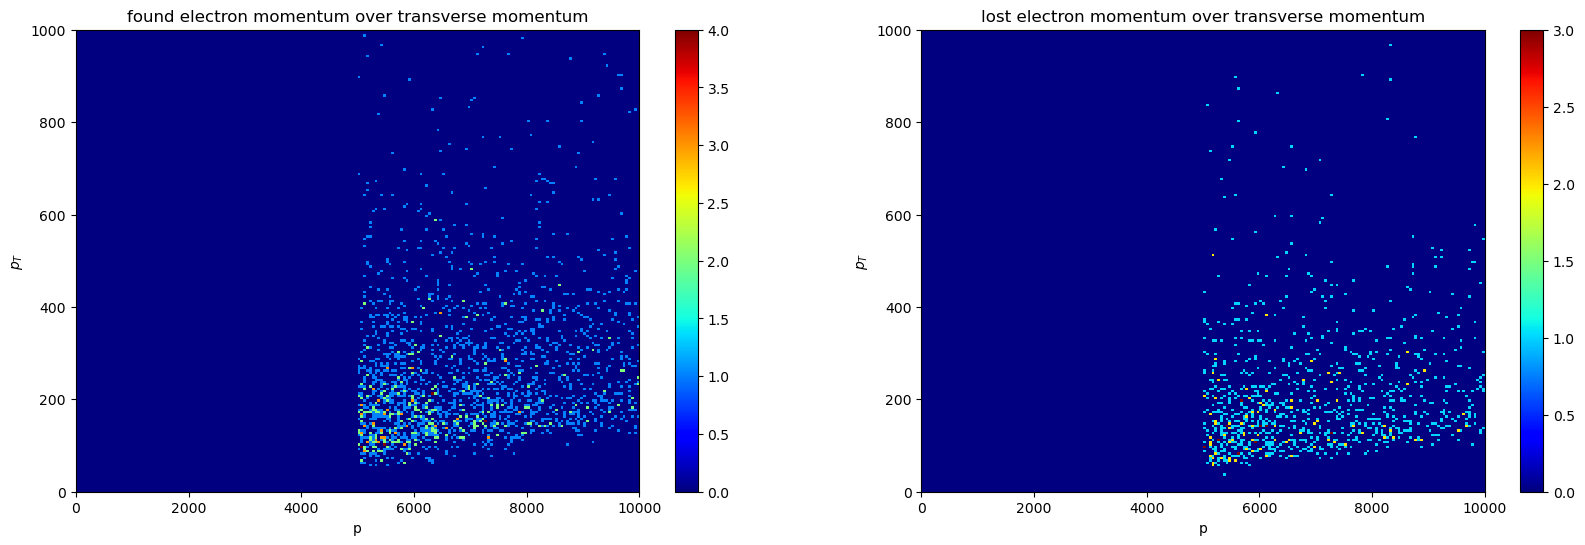

In [57]:
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

a0=ax0.hist2d(p_found, pt_found, bins=200, cmap=plt.cm.jet, cmin=0,range=[[0,1e4],[0,1e3]])
ax0.set_xlabel("p")
ax0.set_ylabel(r"$p_T$")
ax0.set_title("found electron momentum over transverse momentum")
plt.colorbar(a0[3],ax=ax0)

a1=ax1.hist2d(p_lost, pt_lost, bins=200, cmap=plt.cm.jet, cmin=0, range=[[0,1e4],[0,1e3]]) 
ax1.set_xlabel("p")
ax1.set_ylabel(r"$p_T$")
ax1.set_title("lost electron momentum over transverse momentum")
plt.colorbar(a1[3],ax=ax1)

"""
B:

D:
both: clustered between 2000<p<6000 and 20<pt<400 (found a little more spread)
"""
plt.show()

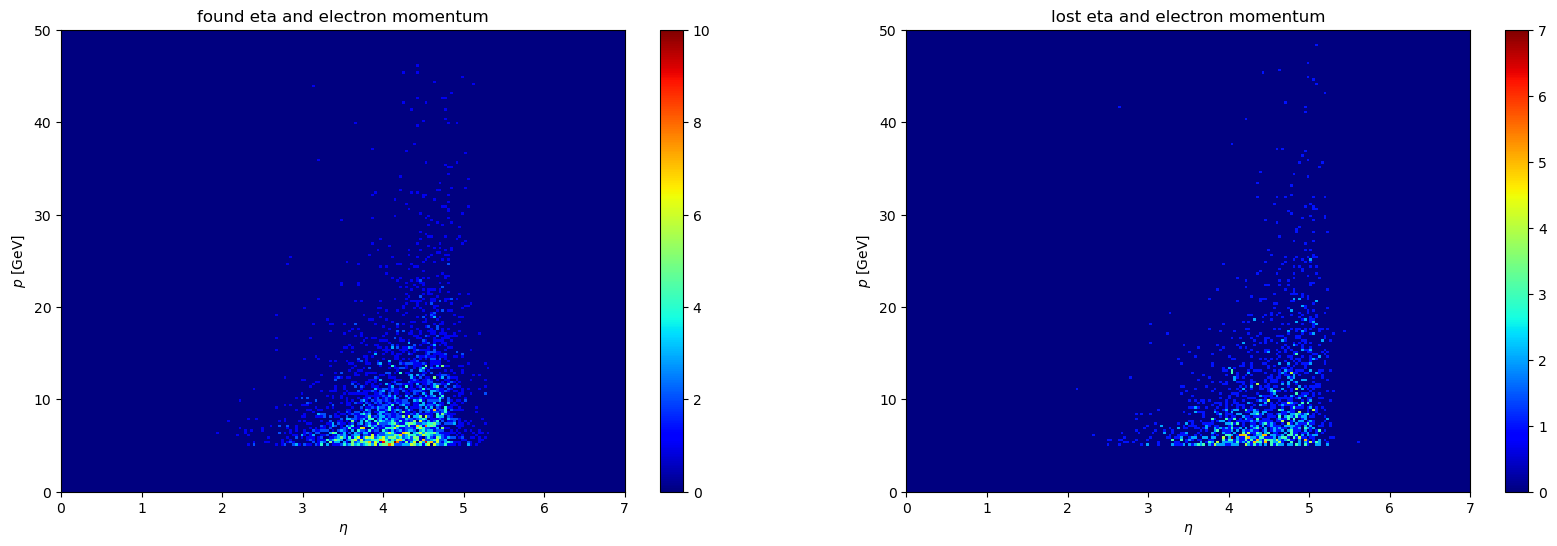

In [58]:
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

a0=ax0.hist2d(eta_found, p_found/(1e3), bins=200, cmap=plt.cm.jet, cmin=0, range=[[0,7],[0,50]])
ax0.set_xlabel(r"$\eta$")
ax0.set_ylabel(r"$p$ [GeV]")
ax0.set_title("found eta and electron momentum")
plt.colorbar(a0[3],ax=ax0)

a1=ax1.hist2d(eta_lost, p_lost/(1e3), bins=200, cmap=plt.cm.jet, cmin=0, range=[[0,7],[0,50]])
ax1.set_xlabel(r"$\eta$")
ax1.set_ylabel(r"$p$ [GeV]")
ax1.set_title("lost eta and electron momentum")
plt.colorbar(a1[3],ax=ax1)

"""
B:
particles with lower momentum appear to have lower rapidity as well, ie a larger angle to the beam axis.
D:
both: clustered between 3<eta<5 and 0<p<10GeV. it seems that most particles had a higher rapidity 
"""
plt.show()

In [16]:
tracked[1].tolist()

{'all_endvtx_types_length': 11,
 'all_endvtx_types': [101.0,
  101.0,
  101.0,
  101.0,
  101.0,
  101.0,
  101.0,
  101.0,
  101.0,
  101.0,
  0.0],
 'all_endvtx_x_length': 11,
 'all_endvtx_x': [19.496400833129883,
  24.957000732421875,
  32.490699768066406,
  34.14419937133789,
  34.6599006652832,
  36.427101135253906,
  -1914.992431640625,
  -2413.033203125,
  -3782.947998046875,
  -3786.80810546875,
  -3819.826904296875],
 'all_endvtx_y_length': 11,
 'all_endvtx_y': [-20.370500564575195,
  -26.043100357055664,
  -33.85060119628906,
  -35.53160095214844,
  -36.069400787353516,
  -37.92850112915039,
  -504.0671081542969,
  -533.6621704101562,
  -598.8317260742188,
  -599.1124877929688,
  -593.3890991210938],
 'all_endvtx_z_length': 11,
 'all_endvtx_z': [399.7018127441406,
  500.7049865722656,
  637.5723266601562,
  667.4852905273438,
  677.0195922851562,
  709.4874877929688,
  8576.556640625,
  9281.2119140625,
  11183.1640625,
  11188.4541015625,
  11237.0966796875],
 'brem_photons_